In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.model_selection import train_test_split

In [4]:
PATH = "data/statoil"

In [5]:
sz=75*75

In [7]:
!ls {PATH}

composites  prediction1.csv  sample_submission.csv  test.json  train.json


In [8]:
train = pd.read_json("data/statoil/train.json")

In [9]:
test  = pd.read_json("data/statoil/test.json")

In [10]:
sample_submission = pd.read_csv("data/statoil/sample_submission.csv")

In [14]:
sample_submission.head()

,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5
2,b20200e4,0.5
3,e7f018bb,0.5
4,4371c8c3,0.5


In [13]:
test.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [15]:
train.inc_angle = train.inc_angle.apply(lambda x:np.nan if x == 'na' else x)

In [35]:
img1 = test.loc[0, ['band_1','band_2','is_iceberg']]

In [36]:
img1

band_1        [-15.863251, -15.201077, -17.887735, -19.17248...
band_2        [-21.629612, -21.142353, -23.908337, -28.34524...
is_iceberg                                                  NaN
Name: 0, dtype: object

In [37]:
img1 = np.stack([img1['band_1'],img1['band_2']],-1).reshape(75,75,2)

In [38]:
img1.shape

(75, 75, 2)

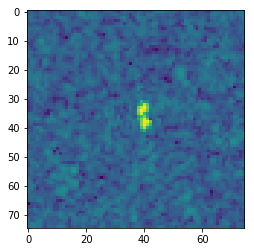

In [41]:
plt.imshow(img1[:,:,0])

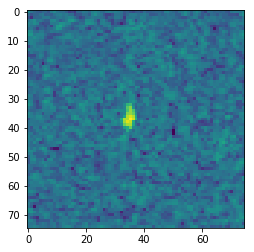

In [21]:
plt.imshow(img1[:,:,1])

In [22]:
combined = img1[:, :, 0] / img1[:, :, 1]

In [23]:
r = img1[:, :, 0]
r = (r + abs(r.min())) / np.max((r + abs(r.min())))

g = img1[:, :, 1]
g = (g + abs(g.min())) / np.max(g + abs(g.min()))

b = img1[:, :, 0] / img1[:, :, 1]
b = (((b) / np.max(b)) + abs((b) / np.max(b))) / np.max((((b) / np.max(b)) + abs((b) / np.max(b))))

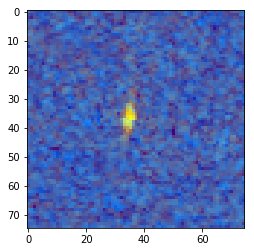

In [24]:
plt.imshow(np.dstack((r, g, b)))

In [25]:
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

In [26]:
rgb_train = color_composite(train)

In [27]:
rgb_test = color_composite(test)

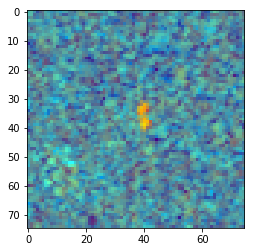

In [34]:
plt.imshow(rgb_test[0])

In [25]:
rgb_test.shape

(8424, 75, 75, 3)

## LOOKING AT RANDOM SHIPS AND ICEBERGS AFTER COLOR COMPOSITE
.Color composition might allow us to identify different characteristics of images
.Of course brightness of the images is effected by incidence angle but we will deal with it later
.My general conclusion after color composition was that icebergs are showing more coherent and similar patterns within themselves where as ships are varying more

Looking at random ships


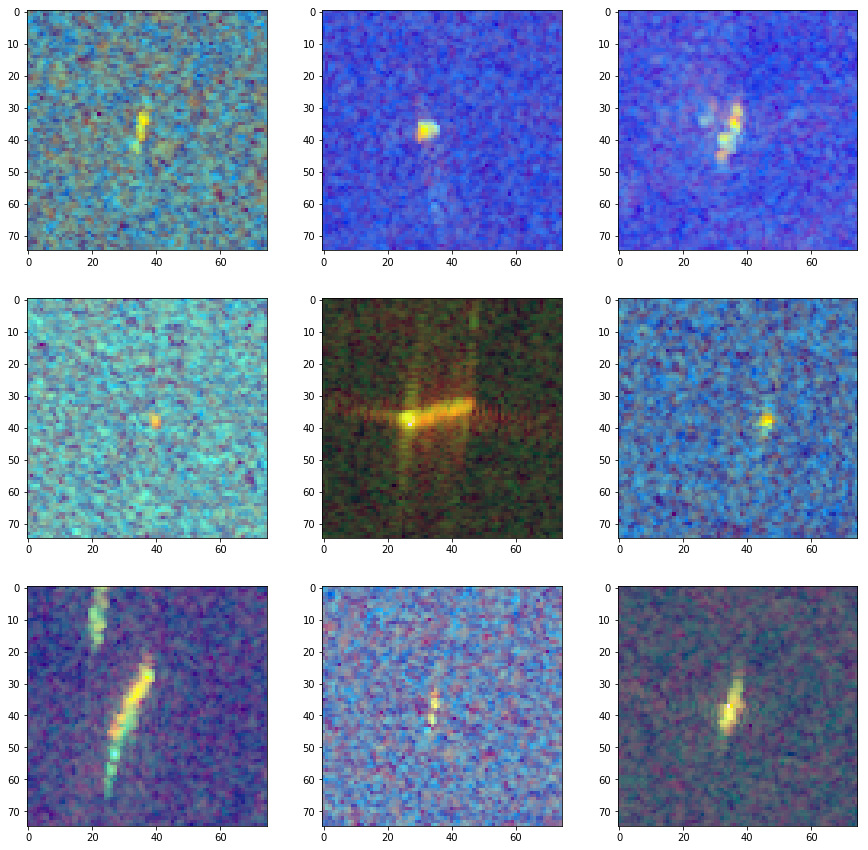

In [26]:
# look at random ships
print('Looking at random ships')
ships = np.random.choice(np.where(train.is_iceberg ==0)[0], 9)
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = rgb_train[ships[i], :, :]
    ax.imshow(arr)
    
plt.show()

Looking at random icebergs


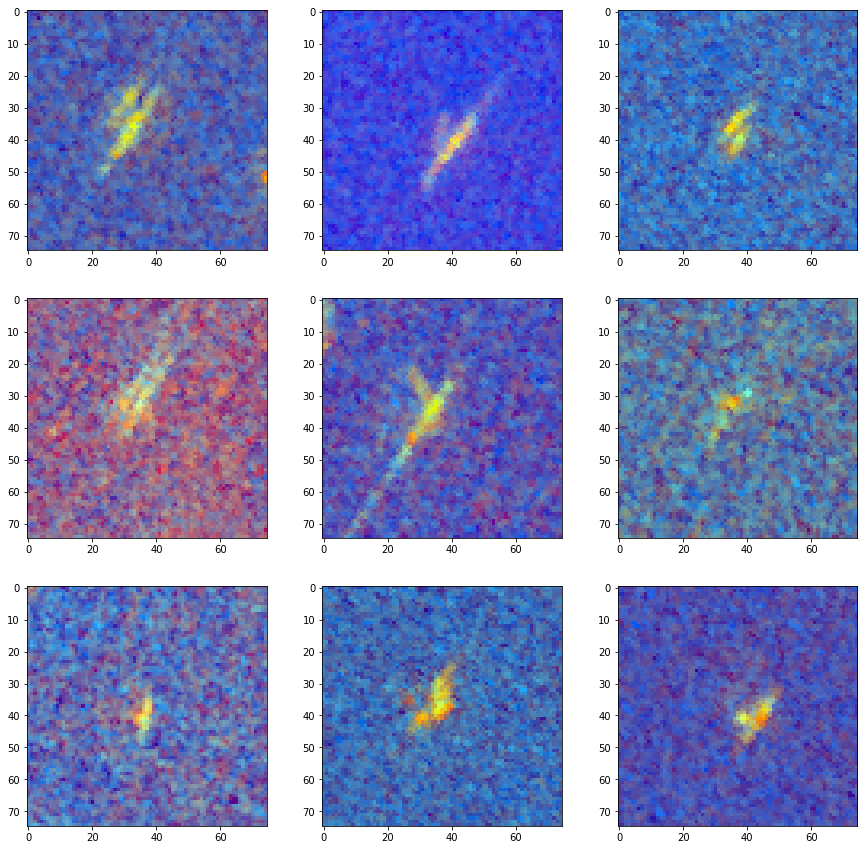

In [27]:
# look at random icebergs
print('Looking at random icebergs')
icebergs = np.random.choice(np.where(train.is_iceberg ==1)[0], 9)
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = rgb_train[icebergs[i], :, :]
    ax.imshow(arr)
    
plt.show()

Looking at random test images


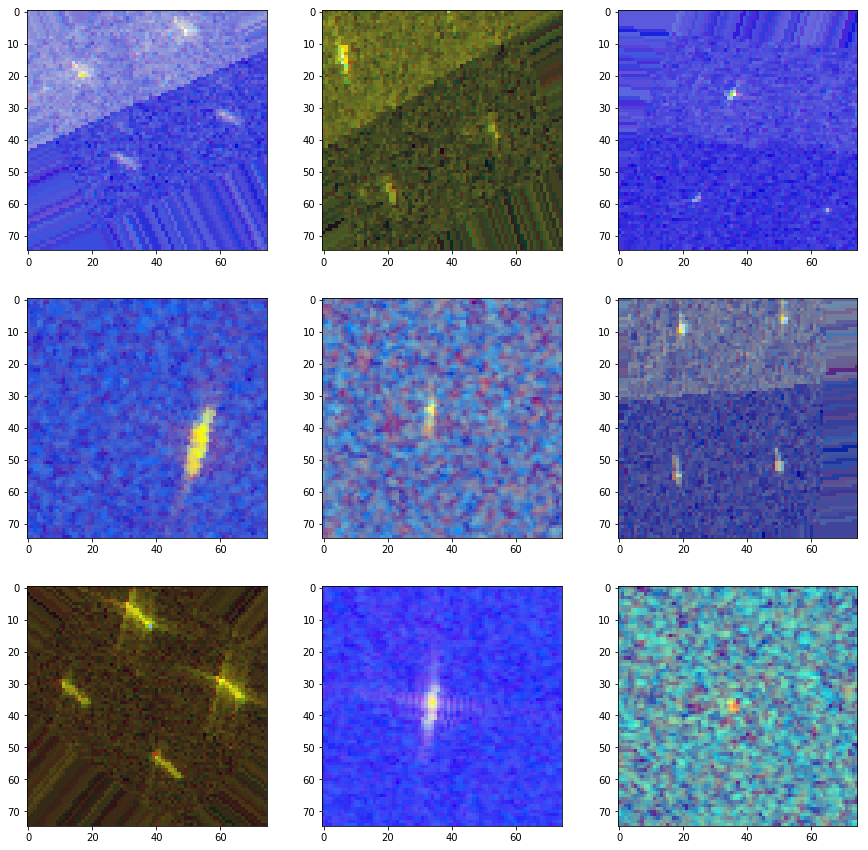

In [28]:
idx = np.random.choice(range(0, len(test)), 9)
test_img = color_composite(test.iloc[idx])

# look at random icebergs
print('Looking at random test images')
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = test_img[i, :, :]
    ax.imshow(arr)
    
plt.show()

SAVE NEW IMAGES

This might be useful for dataloaders reading data from folders as train valid and test

In [31]:

os.makedirs('./data/statoil/composites', exist_ok= True)
os.makedirs('./data/statoil/composites/train', exist_ok=True)
os.makedirs('./data/statoil/composites/valid', exist_ok=True)
os.makedirs('./data/statoil/composites/test', exist_ok=True)
os.makedirs('./data/statoil/composites/valid/ship', exist_ok=True)
os.makedirs('./data/statoil/composites/valid/iceberg', exist_ok=True)
os.makedirs('./data/statoil/composites/train/ship', exist_ok=True)
os.makedirs('./data/statoil/composites/train/iceberg', exist_ok=True)

train_y, test_y = train_test_split(train.is_iceberg, test_size=0.3)
train_index, test_index = train_y.index, test_y.index

#save train images
for idx in train_index:
    if train_y[idx] == 0:
        img = rgb_train[idx]
        plt.imsave('./data/statoil/composites/train/ship/' + str(idx) + '.jpg',  img)
    if train_y[idx] == 1:
        img = rgb_train[idx]
        plt.imsave('./data/statoil/composites/train/iceberg/' + str(idx) + '.jpg',  img)

#save valid images
for idx in test_index:
    if test_y[idx] == 0:
        img = rgb_train[idx]
        plt.imsave('./data/statoil/composites/valid/ship/' + str(idx) + '.jpg',  img)
    if test_y[idx] == 1:
        img = rgb_train[idx]
        plt.imsave('./data/statoil/composites/valid/iceberg/' + str(idx) + '.jpg',  img)
#save test images
for idx in range(len(test)):
    img = rgb_test[idx]
    plt.imsave('./data/statoil/composites/test/' + str(idx) + '.jpg',  img)

In [32]:
rgb_test[0]

array([[[ 0.31887,  0.70163,  0.66675],
        [ 0.33835,  0.72848,  0.65793],
        [ 0.2593 ,  0.57607,  0.6758 ],
        ..., 
        [ 0.36938,  0.59969,  0.58661],
        [ 0.4061 ,  0.56423,  0.5451 ],
        [ 0.37351,  0.43867,  0.54253]],

       [[ 0.30322,  0.7371 ,  0.69605],
        [ 0.33835,  0.72848,  0.65793],
        [ 0.30322,  0.42217,  0.59366],
        ..., 
        [ 0.33137,  0.42244,  0.57179],
        [ 0.37351,  0.62196,  0.58935],
        [ 0.38156,  0.48428,  0.54649]],

       [[ 0.33122,  0.57606,  0.61321],
        [ 0.36293,  0.57607,  0.58562],
        [ 0.28366,  0.48401,  0.62606],
        ..., 
        [ 0.28381,  0.56423,  0.65058],
        [ 0.33377,  0.62196,  0.62518],
        [ 0.37957,  0.5518 ,  0.56474]],

       ..., 
       [[ 0.35643,  0.48395,  0.56686],
        [ 0.28071,  0.57602,  0.65715],
        [ 0.31885,  0.53871,  0.61277],
        ..., 
        [ 0.31645,  0.59965,  0.6335 ],
        [ 0.2325 ,  0.69258,  0.74583],
     